In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk

In [2]:
#prepocessing
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()


tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}



def preprocessing(sentence):
    sent = tokenizer.tokenize(sentence.lower().strip())
    tags = nltk.pos_tag(sent)


    sent = ([lemmatizer.lemmatize(item[0], tag_dict.get(item[1][0], wordnet.NOUN)) for item in tags])
    return " ".join(sent)



In [3]:
#get and clean the training data
df = pd.read_csv("train.csv")
df['sentiment'].replace("positive",1 ,inplace=True)
df['sentiment'].replace("negative", 0,inplace=True)
df["review"] = df["review"].apply(lambda x: preprocessing(x))
X = df["review"]
Y= df["sentiment"]

In [6]:
from sklearn.model_selection import KFold
from time import process_time
def EvaluateModel(model,Xdata,ydata,folds,vectorizer):
    accuracy = []
    traintime = []
    predicttime = []
    kf = KFold(n_splits=folds)
    for train_index, test_index in kf.split(Xdata):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = Xdata[train_index], Xdata[test_index]
        y_train, y_test = ydata[train_index], ydata[test_index]
        t1 = process_time()
        X_matrix = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
        clf = model
        clf.fit(X_matrix,y_train)
        t2=process_time()
        traintime.append((t2-t1)/X_matrix.shape[0])
#         X_test_dense = np.asarray(X_test_vec.todense())
        
        print("predicting")
        preds = clf.predict(X_test_vec)
        t3 = process_time()
        predicttime.append((t3-t2)/y_test.shape[0])
        correct = 0
        for i in range(len(preds)):
            if preds[i] == y_test.iloc[i]:
                correct +=1
        accuracy.append(correct/len(preds))
    return accuracy,traintime,predicttime
    

In [ ]:
class NaiveBayes:
    def __init__(self):
        self.theta0 = None
        self.theta1 = None
        self.xj_mat = None
    def fit(self, X_Train, Y_train ):
        self.theta0 = (Y_train==0).sum()/float(Y_train.shape[0])
        self.theta1 = (Y_train==1).sum()/float(Y_train.shape[0])
        
        #create the p(xj|y=k) matrix
        x_1 = (X_Train.T.dot(Y_train)+1) / (( (Y_train ==1).sum())+2)
        invY = 1 - Y_train
        x_0 = (X_Train.T.dot(invY)+1) / (( (invY ==1).sum())+2)
        
        x_1[x_1 >= 1] = 0.999999 #fix if there is any issue with laplace smoothing
        x_0[x_0 >= 1] = 0.999999
        
        self.xj_mat = np.vstack((x_0,x_1))
   
    def predict(self, X_test):
        X_test = np.asarray(X_test.todense()) #changed something here but it should still work
        preds_list = []
        for i in range(len(X_test)):
            x=X_test[i]
            num_features = len(x)
            llh = 0
            for j in range(num_features):
                llh += x[j]*np.log(self.xj_mat[1][j]/self.xj_mat[0][j]) + (1-x[j])*np.log((1-self.xj_mat[1][j])/(1-self.xj_mat[0][j]))
            llh += np.log(self.theta1/ self.theta0)
            predicted_label = 1 if llh >= 0 else 0
            preds_list.append(predicted_label)
        return preds_list
    
    def get_nb_embeddings(self): #returns naive bayes embeddings
        return self.xj_mat

#evaluate model
vectorizer = CountVectorizer(binary=True,ngram_range=(1,2),max_features=5000)
acc_nb, trnT_nb, predT_nb = EvaluateModel(model=NaiveBayes(),folds=10,Xdata=X,ydata=Y,vectorizer=vectorizer)

In [ ]:
print(acc_nb)
print(trnT_nb)
print(predT_nb)

In [ ]:
from sklearn.linear_model import LogisticRegression

class NB_LR:
    def __init__(self):
        self.LRmodel = None
        self.nbweights = None
        self.log_odds= None
    def fit(self, X_Train, Y_train ):
        nbmodel = NaiveBayes()
        nbmodel.fit(X_Train,Y_train)
        self.nbweights= nbmodel.get_nb_embeddings()
        self.log_odds = np.log(self.nbweights[1] / self.nbweights[0]).reshape((1,self.nbweights.shape[1]))
        xnb = X_Train.multiply(self.log_odds)
        self.LRmodel = LogisticRegression(C=0.1)
        self.LRmodel.fit(xnb,Y_train)

   
    def predict(self, X_test):
        preds = []
        preds = self.LRmodel.predict(X_test.multiply(self.log_odds))
        return preds
    def predict_proba(self,X_test):
        preds = []
        preds = self.LRmodel.predict_proba(X_test.multiply(self.log_odds))
        return preds
    
vectorizer = CountVectorizer(binary=True,ngram_range=(1,2),max_features=50000)
acc_nblr, trnT_nblr, predT_nblr = EvaluateModel(model=NB_LR(),folds=10,Xdata=X,ydata=Y,vectorizer=vectorizer)
print(acc_nblr)
print(trnT_nblr)
print(predT_nblr)

In [ ]:
vectorizer = CountVectorizer(binary=True,ngram_range=(1,2),max_features=50000)
acc_lr, trnT_lr, predT_lr = EvaluateModel(model=LogisticRegression(),folds=10,Xdata=X,ydata=Y,vectorizer=vectorizer)
vectorizer = TfidfVectorizer(binary=False,ngram_range=(1,2),max_features=50000)

acc_tfidf, trnT_tfidf, predT_tfidf = EvaluateModel(model=LogisticRegression(),folds=10,Xdata=X,ydata=Y,vectorizer=vectorizer)

In [18]:
#create dataframe of experiments
nbresults = [np.array(acc_nb).mean(),np.array(acc_nb).var(), np.array(trnT_nb).mean(), np.array(trnT_nb).var()
             , np.array(predT_nb).mean(), np.array(predT_nb).var()]

nb_lrresults = [np.array(acc_nblr).mean(),np.array(acc_nblr).var(), np.array(trnT_nblr).mean(), np.array(trnT_nblr).var()
             , np.array(predT_nblr).mean(), np.array(predT_nblr).var()]

CV_results =  [np.array(acc_lr).mean(),np.array(acc_lr).var(), np.array(trnT_lr).mean(), np.array(trnT_lr).var()
                 , np.array(predT_lr).mean(), np.array(predT_lr).var()]

TFIDF_rresults =  [np.array(acc_tfidf).mean(),np.array(acc_tfidf).var(), np.array(trnT_tfidf).mean(), np.array(trnT_tfidf).var()
                 , np.array(predT_tfidf).mean(), np.array(predT_tfidf).var()]

results =np.stack((nbresults,nb_lrresults,CV_results,TFIDF_rresults))

dfresults = pd.DataFrame(results,index=["Naive Bayes", "Naive Bayes Embeddings with Logistic Regression",
                                        "CountVec Logistic Regression", "TFIDF Logistic Regression"] ,
                         columns=['Accuracy', 'Accuracy Variance','Train Time (seconds/input)',"Train Variance",
                                 "Test Time (seconds/input)","Test Variance"])
dfresults.to_csv("model_metrics.csv")


In [21]:
#determining thresholds for ensemble:
######################################
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
vectorizer = CountVectorizer(binary=True,ngram_range=(1,2),max_features=1000000)
X_matrix = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model3 = NB_LR()
model3.fit(X_matrix,Y_train)

pred_probs = model3.predict_proba(X_test_vec)



In [46]:
Prob_thresholds =np.arange(0,1,0.05)
FP_rate=[] #what we think is a 1 but is actually a 0
FN_rate=[] #what we think is a 0 but is actually a 1
for j in range(len(Prob_thresholds)):
    TP,TN,FP,FN = 0,0,0,0
    for i in range (len(pred_probs)):
        pred = 1 if pred_probs[i][1]>Prob_thresholds[j] else 0
        
        if pred == 1 and Y_test.iloc[i]==1:
            TP+=1
        if pred == 0 and Y_test.iloc[i]==0:
            TN+=1
        if pred == 1 and  Y_test.iloc[i]==0:
            FP+=1
        if pred == 0 and  Y_test.iloc[i]==1:
            FN+=1
    FP_rate.append(FP/(FP+TN))
    FN_rate.append(FN/(FN+TP))

print(FP_rate)
print(FN_rate)

[1.0, 0.565947242206235, 0.44912641315519014, 0.3723878040424803, 0.3230558410414526, 0.2733812949640288, 0.23775265501884207, 0.20246659815005139, 0.17882836587872558, 0.15176430284343953, 0.13052415210688592, 0.1065433367591641, 0.08701610140459061, 0.06920178143199726, 0.0578965399109284, 0.04316546762589928, 0.030832476875642344, 0.022953066118533743, 0.011990407673860911, 0.005823912298732443]
[0.0, 0.007789678675754625, 0.01525478740668614, 0.021421616358325218, 0.028886725089256736, 0.039272963323596234, 0.04673807205452775, 0.05679974034404414, 0.07172995780590717, 0.08438818565400844, 0.10223953261927946, 0.12333657903278157, 0.14897760467380722, 0.17689061992859462, 0.20967218435572865, 0.2557611165206102, 0.30671859785783834, 0.3765011359948069, 0.4664070107108082, 0.6309639727361246]


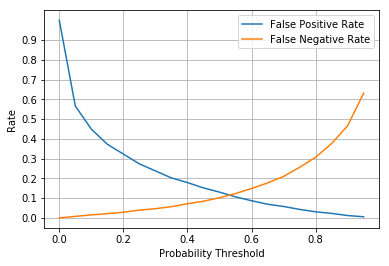

In [45]:
import matplotlib.pyplot as plt
plt.plot(Prob_thresholds,FP_rate,label="False Positive Rate")
plt.plot(Prob_thresholds,FN_rate, label="False Negative Rate")
plt.ylabel("Rate")
plt.xlabel("Probability Threshold")
plt.legend()
plt.yticks(np.arange(0, 1, 0.1))
plt.grid()
plt.show()

In [57]:
#making the final predictions
df = pd.read_csv("train.csv")
df['sentiment'].replace("positive",1 ,inplace=True)
df['sentiment'].replace("negative", 0,inplace=True)
df["review"] = df["review"].apply(lambda x: preprocessing(x))
X = df["review"]
Y= df["sentiment"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0, random_state=42)
vectorizer = CountVectorizer(binary=True,ngram_range=(1,2),max_features=1000000)
x_train_doc = vectorizer.fit_transform(X_train)

df_test = pd.read_csv("test.csv")
df_test["review"] = df_test["review"].apply(lambda x: preprocessing(x))
X_Test =df_test["review"]

x_test = vectorizer.transform(X_Test)
model = NB_LR()
model.fit(x_train_doc,Y_train)


In [68]:
preds = model.predict_proba(x_test)

df_bert_preds = pd.read_csv("bert_large_dropout_05_feb23.csv")
df_bert_preds.head()
changes=0
for i, row in df_bert_preds.iterrows():
    if preds[i][0] >0.8 and row["sentiment"] == "positive":
        row["sentiment"] = "negative"
        changes+=1
    elif preds[i][1] >0.8 and row["sentiment"] == "negative":
        row["sentiment"] = "positive"
        changes+=1

print(changes)

df_bert_preds.head(20)

df_bert_preds.to_csv("ensemble.csv")

241


,id,sentiment
0,0,positive
1,1,positive
2,2,positive
3,3,negative
4,4,positive
5,5,negative
6,6,positive
7,7,negative
8,8,positive
9,9,negative
